# About the project
In this project I will experiment with different residual connections. However, whereas a normal resiudal connection only add the input from the block/bottleneck, I will instead try scaling the input with different factors. This will therefore be a quantity focused experiment, where each trial will be run 10 times each. The experiments will be run through kaggle with a Nvidia Tesla P100.

In [ ]:
from datetime import datetime
from typing import Any, Optional, Callable

import torch
import torchvision
import torchvision.models
from torch import Tensor, nn
from torch.functional import F
from torch.utils.data import DataLoader
from torchvision.models.resnet import Bottleneck, _resnet, ResNet, conv1x1, conv3x3
from torchvision.transforms import ToTensor

## Defining the bottleneck
We need to modify the original bottleneck class from ResNet to fit our needs. Here we are modifying the forward method so we can scale the input. The scaling factor is defined before each trial and will be printed out to be sure we are using the correct one.

In [ ]:
class ScaledBottleneck(nn.Module):
    expansion: int = 4

    def __init__(
            self,
            inplanes: int,
            planes: int,
            stride: int = 1,
            downsample: Optional[nn.Module] = None,
            groups: int = 1,
            base_width: int = 64,
            dilation: int = 1,
            norm_layer: Optional[Callable[..., nn.Module]] = None,
    ) -> None:
        super().__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.0)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride
        self.scaling_factor = scaling_factor
        print("Using scaling factor:", self.scaling_factor)

    def forward(self, x: Tensor) -> Tensor:
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += (identity * self.scaling_factor)
        out = self.relu(out)

        return out

# Scaled vs Baseline
We will test the original resnet50 to serve as a baseline

In [ ]:
def custom_resnet50(progress: bool = True, scaled=True, **kwargs: Any) -> ResNet:
    if scaled:
        return _resnet(ScaledBottleneck, [3, 4, 6, 3], weights=None, progress=False, **kwargs)
    else:
        return _resnet(Bottleneck, [3, 4, 6, 3], weights=None, progress=False, **kwargs)


In [ ]:
class ResNetNetwork(torch.nn.Module):

    def __init__(self, scaled=True):
        super().__init__()

        self.net = custom_resnet50(scaled=scaled)
        self.fc_in_features = self.net.fc.in_features

        self.net.conv1 = nn.Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(1, 1))
        self.net = nn.Sequential(*(list(self.net.children())[:-1]))

        self.fc = nn.Sequential(
            nn.Linear(self.fc_in_features, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 10), )

    def forward(self, x):
        # Forward pass
        output = self.net(x)
        output = output.view(output.size()[0], -1)
        output = self.fc(output)
        return output

## Trial pipeline
Originally the plan was to use the MNIST dataset. However, this proved to be a little too easy and made it hard to evaluate the performance difference of the models. SVHN was therefore used in the final trials.

We save all output from the model to evaluate it later.

In [ ]:


class TrialPipeline():

    def __init__(self, batch_size: int, num_workers: int, epochs: int, lr: float, device,
                 scaled=True) -> None:
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.epochs = epochs
        self.lr = lr
        self.device = device
        self.scaled = scaled

        self.timestamp = datetime.fromtimestamp(datetime.now().timestamp()).strftime("%d-%m-%Y, %H:%M:%S")

        # self.train_dataset = MNIST(root="data", download=True, transform=ToTensor(), train=True)
        self.train_dataset = torchvision.datasets.SVHN(root="data", split="train", download=True, transform=ToTensor())
        self.test_dataset = torchvision.datasets.SVHN(root="data", split="test", download=True, transform=ToTensor())
        # self.test_dataset = MNIST(root="data", download=True, transform=ToTensor(), train=False)

        self.model = ResNetNetwork(scaled=scaled)

        self.train_dataloader = DataLoader(self.train_dataset, batch_size=self.batch_size,
                                           num_workers=self.num_workers, shuffle=True)
        self.val_dataloader = DataLoader(self.train_dataset, batch_size=self.batch_size,
                                         num_workers=self.num_workers, shuffle=False)
        self.test_dataloader = DataLoader(self.test_dataset, batch_size=self.batch_size, shuffle=True,
                                          num_workers=self.num_workers)

    def run_trial(self):
        model, data = self.train_pipeline()
        data = self.test_pipeline(model, data)

        df = pd.DataFrame(data)
        if self.scaled:
            df.to_csv(f"{self.timestamp}-{scaling_factor}")
        else:
            df.to_csv(f"{self.timestamp}-baseline")

    def train_pipeline(self):
        # train_subsampler = torch.utils.data.SubsetRandomSampler(train_idx)
        # val_subsampler = torch.utils.data.SubsetRandomSampler(val_idx)

        net = self.model
        net = net.to(self.device)

        adam = torch.optim.Adam(net.parameters(), lr=self.lr, weight_decay=0.001)
        best_loss = float('inf')
        best_epoch = 0

        train_losses = []
        train_accuracies = []

        val_losses = []
        val_accuracies = []

        for epoch in range(self.epochs):
            print(f"--EPOCH {epoch + 1}--")

            train_loss, train_acc = self.train_single_epoch(model=net, optimizer=adam, dataloader=self.train_dataloader)
            train_losses.append(train_loss)
            train_accuracies.append(train_acc)
            print(f"Train loss {train_loss:.5f}, Train acc {train_acc:.5f}")

            val_loss, val_acc = self.validate(model=net, dataloader=self.val_dataloader)
            val_losses.append(val_loss)
            val_accuracies.append(val_acc)
            print(f"Val loss {val_loss:.5f}, Val acc {val_acc:.5f}")

        data = {"Train losses": train_losses,
                "Train accuracies": train_accuracies,
                "Val losses": val_losses,
                "Val accuracies": val_accuracies
                }
        return net, data

    def train_single_epoch(self, model, optimizer, dataloader):
        model.train()

        losses = []
        total = 0.
        correct = 0
        for imgs, labels in dataloader:
            optimizer.zero_grad()
            imgs, labels = imgs.to(device), labels.to(self.device)

            out = model(imgs)
            _, predicted = torch.max(out.data, 1)

            loss = F.cross_entropy(out, labels)
            losses.append(loss.cpu().detach().numpy())
            loss.backward()

            optimizer.step()
            total += len(imgs)
            correct += (predicted == labels).sum().item()

        losses = np.array(losses)
        return losses.mean() / len(dataloader), correct / total

    def validate(self, model, dataloader):
        model.eval()

        losses = []
        total = 0.
        correct = 0

        with torch.no_grad():
            for imgs, labels in dataloader:
                imgs, labels = imgs.to(device), labels.to(self.device)

                out = model(imgs)
                _, predicted = torch.max(out.data, 1)

                loss = F.cross_entropy(out, labels)
                losses.append(loss.cpu().detach().numpy())

                total += len(imgs)
                correct += (predicted == labels).sum().item()

        losses = np.array(losses)

        return losses.mean() / len(dataloader), correct / total

    def test_pipeline(self, model, data: dict):

        total = 0.
        correct = 0

        with torch.no_grad():
            for imgs, labels in self.test_dataloader:
                imgs, labels = imgs.to(device), labels.to(device)

                out = model(imgs)
                _, predicted = torch.max(out.data, 1)

                total += len(imgs)
                correct += (predicted == labels).sum().item()

        print(f"Test accuracy {correct / total}")
        data["Test accuracy"] = (correct / total)
        return data

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

## Define hyperparameters
Due to time constraints in Kaggle, I will only be able to perform a limited number of trials. Since I am already running each trial 10 times, I have therefore decided to let the hyperparameteres be constant throughout all trials.

In [ ]:
batch_size = 2048
num_workers = 1
epochs = 50
lr = 0.001


In [ ]:
#Test the original resnet 50

trial = TrialPipeline(batch_size=batch_size,
                      num_workers=num_workers,
                      epochs=epochs,
                      lr=lr,
                      device=device,
                      scaled=False
                      )

trial.run_trial()



In [ ]:

#Compare to original resnet 50
scaling_factor = 1

trial = TrialPipeline(batch_size=batch_size,
                      num_workers=num_workers,
                      epochs=epochs,
                      lr=lr,
                      device=device,
                      scaled=True
                      )

trial.run_trial()


In [ ]:
scaling_factor = 0.4

trial = TrialPipeline(batch_size=batch_size,
                      num_workers=num_workers,
                      epochs=epochs,
                      lr=lr,
                      device=device,
                      scaled=True
                      )

trial.run_trial()


In [ ]:
scaling_factor = 0.6

trial = TrialPipeline(batch_size=batch_size,
                      num_workers=num_workers,
                      epochs=epochs,
                      lr=lr,
                      device=device,
                      scaled=True
                      )

trial.run_trial()


In [ ]:
scaling_factor = 0.8

trial = TrialPipeline(batch_size=batch_size,
                      num_workers=num_workers,
                      epochs=epochs,
                      lr=lr,
                      device=device,
                      scaled=True
                      )

trial.run_trial()


In [ ]:
scaling_factor = 1.2

trial = TrialPipeline(batch_size=batch_size,
                      num_workers=num_workers,
                      epochs=epochs,
                      lr=lr,
                      device=device,
                      scaled=True
                      )

trial.run_trial()


In [ ]:
scaling_factor = 1.4

trial = TrialPipeline(batch_size=batch_size,
                      num_workers=num_workers,
                      epochs=epochs,
                      lr=lr,
                      device=device,
                      scaled=True
                      )

trial.run_trial()


In [ ]:
scaling_factor = 1.6

trial = TrialPipeline(batch_size=batch_size,
                      num_workers=num_workers,
                      epochs=epochs,
                      lr=lr,
                      device=device,
                      scaled=True
                      )

trial.run_trial()


## Read the output from the training
*Yes I know, this was more complicated than it needed to be...*

In [196]:

baselines = [
    "/Users/madslun/Documents/Programmering/ResidualConnectionScaling/training-runs/2nd run/13-03-2023, 13:22:51-baseline",
    "/Users/madslun/Documents/Programmering/ResidualConnectionScaling/training-runs/3rd run/13-03-2023, 20:37:05-baseline",
    "/Users/madslun/Documents/Programmering/ResidualConnectionScaling/training-runs/1st run/13-03-2023, 13:21:27-baseline",
    "/Users/madslun/Documents/Programmering/ResidualConnectionScaling/training-runs/4th run/13-03-2023, 20:37:15-baseline",
    "/Users/madslun/Documents/Programmering/ResidualConnectionScaling/training-runs/5th run/20-03-2023, 11:58:53-baseline",
    "/Users/madslun/Documents/Programmering/ResidualConnectionScaling/training-runs/6th run/20-03-2023, 11:59:01-baseline",
    "/Users/madslun/Documents/Programmering/ResidualConnectionScaling/training-runs/7th run/22-03-2023, 11:57:51-baseline",
    "/Users/madslun/Documents/Programmering/ResidualConnectionScaling/training-runs/8th run/22-03-2023, 11:58:02-baseline",
    "/Users/madslun/Documents/Programmering/ResidualConnectionScaling/training-runs/9th run/27-03-2023, 09:47:16-baseline",
    "/Users/madslun/Documents/Programmering/ResidualConnectionScaling/training-runs/10th run/27-03-2023, 09:47:23-baseline"
]

In [197]:
one_scaling = [
    "/Users/madslun/Documents/Programmering/ResidualConnectionScaling/training-runs/1st run/13-03-2023, 14:05:10-1",
    "/Users/madslun/Documents/Programmering/ResidualConnectionScaling/training-runs/2nd run/13-03-2023, 14:06:49-1",
    "/Users/madslun/Documents/Programmering/ResidualConnectionScaling/training-runs/3rd run/13-03-2023, 21:21:23-1",
    "/Users/madslun/Documents/Programmering/ResidualConnectionScaling/training-runs/4th run/13-03-2023, 21:21:12-1",
    "/Users/madslun/Documents/Programmering/ResidualConnectionScaling/training-runs/5th run/20-03-2023, 12:42:48-1",
    "/Users/madslun/Documents/Programmering/ResidualConnectionScaling/training-runs/6th run/20-03-2023, 12:42:43-1",
    "/Users/madslun/Documents/Programmering/ResidualConnectionScaling/training-runs/7th run/22-03-2023, 12:41:30-1",
    "/Users/madslun/Documents/Programmering/ResidualConnectionScaling/training-runs/8th run/22-03-2023, 12:41:55-1",
    "/Users/madslun/Documents/Programmering/ResidualConnectionScaling/training-runs/9th run/27-03-2023, 10:31:07-1",
    "/Users/madslun/Documents/Programmering/ResidualConnectionScaling/training-runs/10th run/27-03-2023, 10:31:04-1"
]

In [198]:
forth_scaling = [
    "/Users/madslun/Documents/Programmering/ResidualConnectionScaling/training-runs/1st run/13-03-2023, 14:49:34-0.4",
    "/Users/madslun/Documents/Programmering/ResidualConnectionScaling/training-runs/2nd run/13-03-2023, 14:51:15-0.4",
    "/Users/madslun/Documents/Programmering/ResidualConnectionScaling/training-runs/3rd run/13-03-2023, 22:06:01-0.4",
    "/Users/madslun/Documents/Programmering/ResidualConnectionScaling/training-runs/4th run/13-03-2023, 22:05:36-0.4",
    "/Users/madslun/Documents/Programmering/ResidualConnectionScaling/training-runs/5th run/20-03-2023, 13:27:28-0.4",
    "/Users/madslun/Documents/Programmering/ResidualConnectionScaling/training-runs/6th run/20-03-2023, 13:27:08-0.4",
    "/Users/madslun/Documents/Programmering/ResidualConnectionScaling/training-runs/7th run/22-03-2023, 13:25:53-0.4",
    "/Users/madslun/Documents/Programmering/ResidualConnectionScaling/training-runs/8th run/22-03-2023, 13:26:33-0.4",
    "/Users/madslun/Documents/Programmering/ResidualConnectionScaling/training-runs/9th run/27-03-2023, 11:15:34-0.4",
    "/Users/madslun/Documents/Programmering/ResidualConnectionScaling/training-runs/10th run/27-03-2023, 11:15:29-0.4"
]

In [199]:
sixth_scaling = [
    "/Users/madslun/Documents/Programmering/ResidualConnectionScaling/training-runs/1st run/13-03-2023, 15:34:08-0.6",
    "/Users/madslun/Documents/Programmering/ResidualConnectionScaling/training-runs/2nd run/13-03-2023, 15:35:44-0.6",
    "/Users/madslun/Documents/Programmering/ResidualConnectionScaling/training-runs/3rd run/13-03-2023, 22:50:42-0.6",
    "/Users/madslun/Documents/Programmering/ResidualConnectionScaling/training-runs/4th run/13-03-2023, 22:50:05-0.6",
    "/Users/madslun/Documents/Programmering/ResidualConnectionScaling/training-runs/5th run/20-03-2023, 14:12:09-0.6",
    "/Users/madslun/Documents/Programmering/ResidualConnectionScaling/training-runs/6th run/20-03-2023, 14:11:40-0.6",
    "/Users/madslun/Documents/Programmering/ResidualConnectionScaling/training-runs/7th run/22-03-2023, 14:10:22-0.6",
    "/Users/madslun/Documents/Programmering/ResidualConnectionScaling/training-runs/8th run/22-03-2023, 14:11:12-0.6",
    "/Users/madslun/Documents/Programmering/ResidualConnectionScaling/training-runs/9th run/27-03-2023, 12:00:02-0.6",
    "/Users/madslun/Documents/Programmering/ResidualConnectionScaling/training-runs/10th run/27-03-2023, 11:59:59-0.6"
]

In [200]:
eight_scaling = [
    "/Users/madslun/Documents/Programmering/ResidualConnectionScaling/training-runs/1st run/13-03-2023, 16:18:42-0.8",
    "/Users/madslun/Documents/Programmering/ResidualConnectionScaling/training-runs/2nd run/13-03-2023, 16:20:13-0.8",
    "/Users/madslun/Documents/Programmering/ResidualConnectionScaling/training-runs/3rd run/13-03-2023, 23:35:32-0.8",
    "/Users/madslun/Documents/Programmering/ResidualConnectionScaling/training-runs/4th run/13-03-2023, 23:34:35-0.8",
    "/Users/madslun/Documents/Programmering/ResidualConnectionScaling/training-runs/5th run/20-03-2023, 14:56:53-0.8",
    "/Users/madslun/Documents/Programmering/ResidualConnectionScaling/training-runs/6th run/20-03-2023, 14:56:14-0.8",
    "/Users/madslun/Documents/Programmering/ResidualConnectionScaling/training-runs/7th run/22-03-2023, 14:54:50-0.8",
    "/Users/madslun/Documents/Programmering/ResidualConnectionScaling/training-runs/8th run/22-03-2023, 14:55:53-0.8",
    "/Users/madslun/Documents/Programmering/ResidualConnectionScaling/training-runs/9th run/27-03-2023, 12:44:33-0.8",
    "/Users/madslun/Documents/Programmering/ResidualConnectionScaling/training-runs/10th run/27-03-2023, 12:44:32-0.8"
]

In [201]:
one_two_scaling = [
    "/Users/madslun/Documents/Programmering/ResidualConnectionScaling/training-runs/1st run/13-03-2023, 17:03:14-1.2",
    "/Users/madslun/Documents/Programmering/ResidualConnectionScaling/training-runs/2nd run/13-03-2023, 17:04:45-1.2",
    "/Users/madslun/Documents/Programmering/ResidualConnectionScaling/training-runs/3rd run/14-03-2023, 00:20:24-1.2",
    "/Users/madslun/Documents/Programmering/ResidualConnectionScaling/training-runs/4th run/14-03-2023, 00:19:03-1.2",
    "/Users/madslun/Documents/Programmering/ResidualConnectionScaling/training-runs/5th run/20-03-2023, 15:41:36-1.2",
    "/Users/madslun/Documents/Programmering/ResidualConnectionScaling/training-runs/6th run/20-03-2023, 15:40:48-1.2",
    "/Users/madslun/Documents/Programmering/ResidualConnectionScaling/training-runs/7th run/22-03-2023, 15:39:18-1.2",
    "/Users/madslun/Documents/Programmering/ResidualConnectionScaling/training-runs/8th run/22-03-2023, 15:40:33-1.2",
    "/Users/madslun/Documents/Programmering/ResidualConnectionScaling/training-runs/9th run/27-03-2023, 13:29:03-1.2",
    "/Users/madslun/Documents/Programmering/ResidualConnectionScaling/training-runs/10th run/27-03-2023, 13:29:04-1.2"
]

In [202]:
one_four_scaling = [
    "/Users/madslun/Documents/Programmering/ResidualConnectionScaling/training-runs/1st run/13-03-2023, 17:47:46-1.4",
    "/Users/madslun/Documents/Programmering/ResidualConnectionScaling/training-runs/2nd run/13-03-2023, 17:49:13-1.4",
    "/Users/madslun/Documents/Programmering/ResidualConnectionScaling/training-runs/3rd run/14-03-2023, 01:05:15-1.4",
    "/Users/madslun/Documents/Programmering/ResidualConnectionScaling/training-runs/4th run/14-03-2023, 01:03:35-1.4",
    "/Users/madslun/Documents/Programmering/ResidualConnectionScaling/training-runs/5th run/20-03-2023, 16:26:10-1.4",
    "/Users/madslun/Documents/Programmering/ResidualConnectionScaling/training-runs/6th run/20-03-2023, 16:25:20-1.4",
    "/Users/madslun/Documents/Programmering/ResidualConnectionScaling/training-runs/7th run/22-03-2023, 16:23:47-1.4",
    "/Users/madslun/Documents/Programmering/ResidualConnectionScaling/training-runs/8th run/22-03-2023, 16:25:13-1.4",
    "/Users/madslun/Documents/Programmering/ResidualConnectionScaling/training-runs/9th run/27-03-2023, 14:13:32-1.4",
    "/Users/madslun/Documents/Programmering/ResidualConnectionScaling/training-runs/10th run/27-03-2023, 14:13:34-1.4"
]

In [203]:
one_six_scaling = [
    "/Users/madslun/Documents/Programmering/ResidualConnectionScaling/training-runs/1st run/13-03-2023, 18:32:20-1.6",
    "/Users/madslun/Documents/Programmering/ResidualConnectionScaling/training-runs/2nd run/13-03-2023, 18:33:41-1.6",
    "/Users/madslun/Documents/Programmering/ResidualConnectionScaling/training-runs/3rd run/14-03-2023, 01:49:59-1.6",
    "/Users/madslun/Documents/Programmering/ResidualConnectionScaling/training-runs/4th run/14-03-2023, 01:48:06-1.6",
    "/Users/madslun/Documents/Programmering/ResidualConnectionScaling/training-runs/5th run/20-03-2023, 17:10:45-1.6",
    "/Users/madslun/Documents/Programmering/ResidualConnectionScaling/training-runs/6th run/20-03-2023, 17:09:54-1.6",
    "/Users/madslun/Documents/Programmering/ResidualConnectionScaling/training-runs/7th run/22-03-2023, 17:08:19-1.6",
    "/Users/madslun/Documents/Programmering/ResidualConnectionScaling/training-runs/8th run/22-03-2023, 17:09:54-1.6",
    "/Users/madslun/Documents/Programmering/ResidualConnectionScaling/training-runs/9th run/27-03-2023, 14:58:06-1.6",
    "/Users/madslun/Documents/Programmering/ResidualConnectionScaling/training-runs/10th run/27-03-2023, 14:58:06-1.6"
]

In [204]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt



## Define methods to visualize the results

In [205]:

def calculate(df_grouped_by):
    df_grouped = df_grouped_by.droplevel(axis=1, level=0).reset_index()
    # Calculate a confidence interval as well.
    df_grouped['ci'] = 1.96 * df_grouped['std'] / np.sqrt(df_grouped['count'])
    df_grouped['ci_lower'] = df_grouped['mean'] - df_grouped['ci']
    df_grouped['ci_upper'] = df_grouped['mean'] + df_grouped['ci']

    return df_grouped


def read_files(files_arr: list):
    df_list = (pd.read_csv(file) for file in files_arr)
    return pd.concat(df_list, ignore_index=True)


def group_by(big_df, target: str):
    return (
        big_df[['Unnamed: 0', target]].groupby(['Unnamed: 0'])
        .agg(['mean', 'std', 'count'])
    )


def display(files_arr: list, name: str):
    big_df = read_files(files_arr)

    train_accuracies = group_by(big_df, 'Train accuracies')
    train_acc_df = calculate(train_accuracies)

    val_accuracies = group_by(big_df, 'Val accuracies')
    val_acc_df = calculate(val_accuracies)

    train_loss = group_by(big_df, 'Train losses')
    train_loss_df = calculate(train_loss)

    val_loss = group_by(big_df, 'Val losses')
    val_loss_df = calculate(val_loss)

    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))
    x = train_acc_df['Unnamed: 0']
    ax[0][0].plot(x, train_acc_df['mean'])
    ax[0][1].plot(x, val_acc_df['mean'])
    ax[1][0].plot(x, train_loss_df['mean'])
    ax[1][1].plot(x, val_loss_df['mean'])

    ax[0][0].fill_between(
        x, train_acc_df['ci_lower'], train_acc_df['ci_upper'], color='y', alpha=.15)
    ax[0][1].fill_between(
        x, val_acc_df['ci_lower'], val_acc_df['ci_upper'], color='y', alpha=.15)
    ax[1][0].fill_between(
        x, train_loss_df['ci_lower'], train_loss_df['ci_upper'], color='y', alpha=.15)
    ax[1][1].fill_between(
        x, val_loss_df['ci_lower'], val_loss_df['ci_upper'], color='y', alpha=.15)

    ax[0][0].set_ylim(ymin=0)
    ax[0][0].set_ylim(ymax=1)
    ax[0][0].set_title(f'{name} - Train accuracy')

    ax[0][1].set_ylim(ymin=0)
    ax[0][1].set_ylim(ymax=1)
    ax[0][1].set_title(f'{name} - Val accuracy')

    ax[1][0].set_ylim(ymin=0)
    ax[1][0].set_ylim(ymax=0.1)
    ax[1][0].set_title(f'{name} - Train loss')

    ax[1][1].set_ylim(ymin=0)
    ax[1][1].set_ylim(ymax=0.1)
    ax[1][1].set_title(f'{name} - Val loss')

    fig.autofmt_xdate(rotation=45)

    plt.figure(0)

    train_acc_row = train_acc_df[train_acc_df['mean'].max() == train_acc_df['mean']]
    val_acc_row = val_acc_df[val_acc_df['mean'].max() == val_acc_df['mean']]
    train_loss_row = train_loss_df[train_loss_df['mean'].min() == train_loss_df['mean']]
    val_loss_row = val_loss_df[val_loss_df['mean'].min() == val_loss_df['mean']]

    table = plt.table(cellText=[
        [train_acc_row['mean'].values[0], train_acc_row['std'].values[0], train_acc_row['Unnamed: 0'].values[0]],
        [val_acc_row['mean'].values[0], val_acc_row['std'].values[0], val_acc_row['Unnamed: 0'].values[0]],
        [train_loss_row['mean'].values[0], train_loss_row['std'].values[0], train_loss_row['Unnamed: 0'].values[0]],
        [val_loss_row['mean'].values[0], val_loss_row['std'].values[0], val_loss_row['Unnamed: 0'].values[0]],
    ],

        colLabels=['Max/Min (mean)', 'std', 'Epoch'],
        rowLoc='right',
        rowLabels=['Train accuracy', 'Val accuracy', 'Train loss', 'Val loss'],
        loc='center',
    )
    plt.axis("off")
    table.set_fontsize(58)
    table.scale(2, 5)

## Baseline
We can see that the baseline model increases quite rapidly, in terms of train and val accuracy. However, as the train accuracy stabilizes, it seems like it hit some dips in terms of val accuracy. The dips seem to match quite good with the val loss.

Whereas the train accuracy has a quite small confidence interval, the val accuracy has much bigger confidence interval in general, with certain points having a really broad confidence interval.

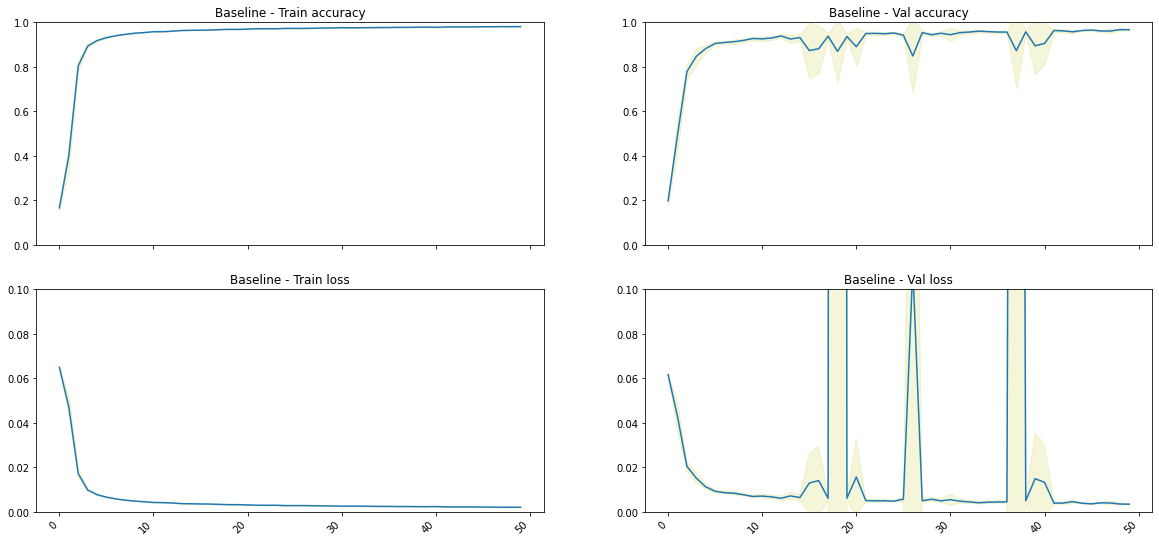

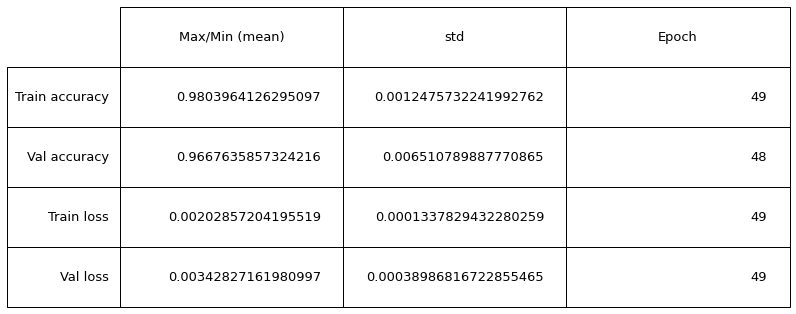

In [206]:
display(baselines, "Baseline")

## Scaling factor of 1.0
This trial is used to compare the scaling model to the baseline. As we are multiplying with 1, we should get more or less the same results as the baseline. As we can see, this seems to fit quite accurately. The train accuracy increases rapidly, the val accuracy increases rapid, but has a bigger confidence interval, lastly, the val loss decreases but has some huge spikes. All quite similar to the baseline.

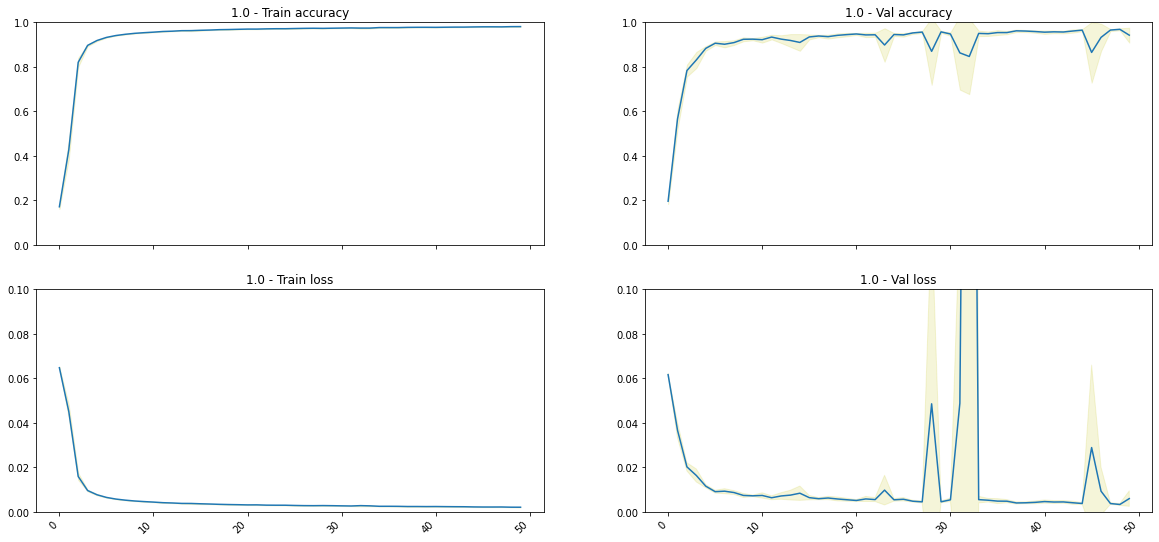

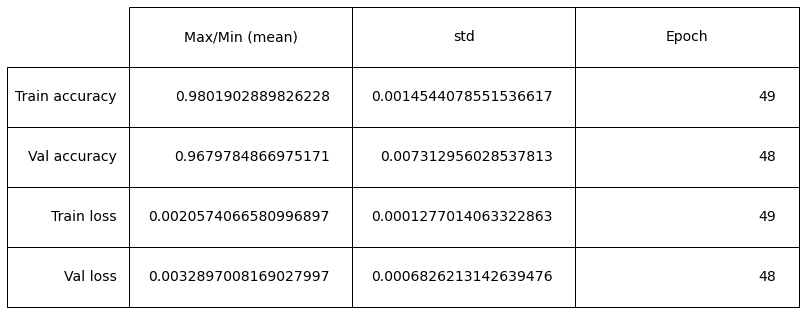

In [207]:
display(one_scaling, "1.0")

## Scaling factor of 0.4
This is where the trials really begin, and we can se the effect of having different scaling factors.

The train accuracy has a much more gentle slope and does not stabilize like the baseline model did. It also has a much bigger confidence interval compared to the baseline. The same applies to the train loss.

Looking at the val accuracy we can see some real difference. The val accuracy does not stabilize at al, and has a immense confidence interval.

Looking at the val loss we observe even worse results. It does not appear to follow a specific path and has a enormous confidence interval.

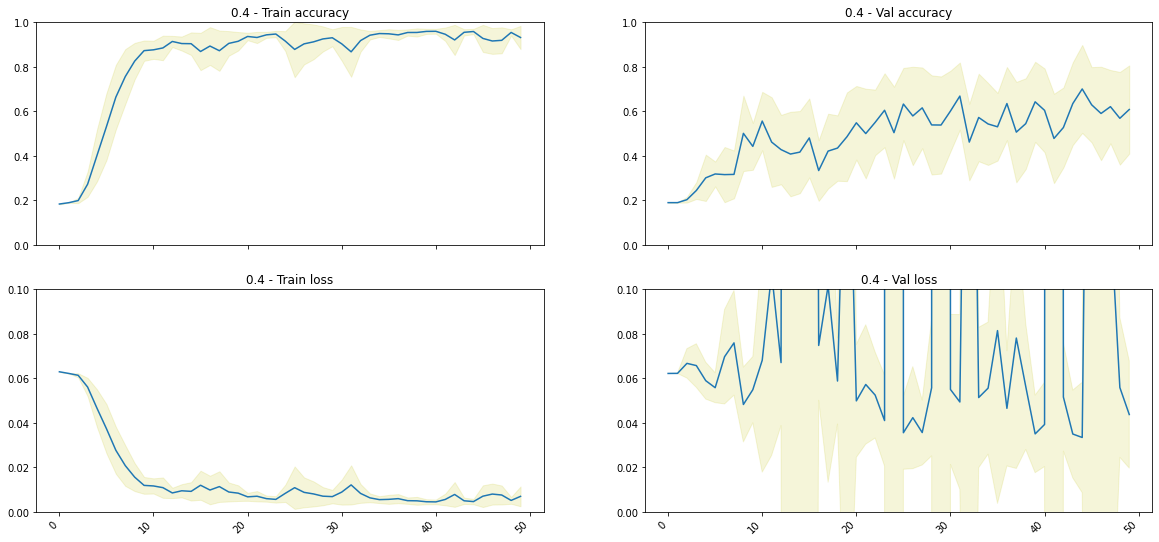

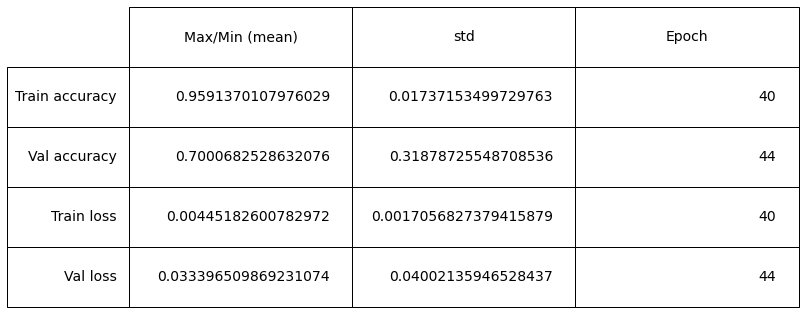

In [208]:
display(forth_scaling, "0.4")

## Scaling factor of 0.6
Already at the scaling factor of 0.6 we can se a big difference. The train accuracy has a much steeper incline compare to the previous, and seem to stabilize a bit better. The same applies to the train loss.

Looking at the val accuracy we can, however, see that it does not stabilize like the baseline models. It has certain points where it has a big dip, and the same can be said of its confidence interval.

Although the val loss has improved compare to the 0.4 case, we can still see that it has a lot of fluctuations.

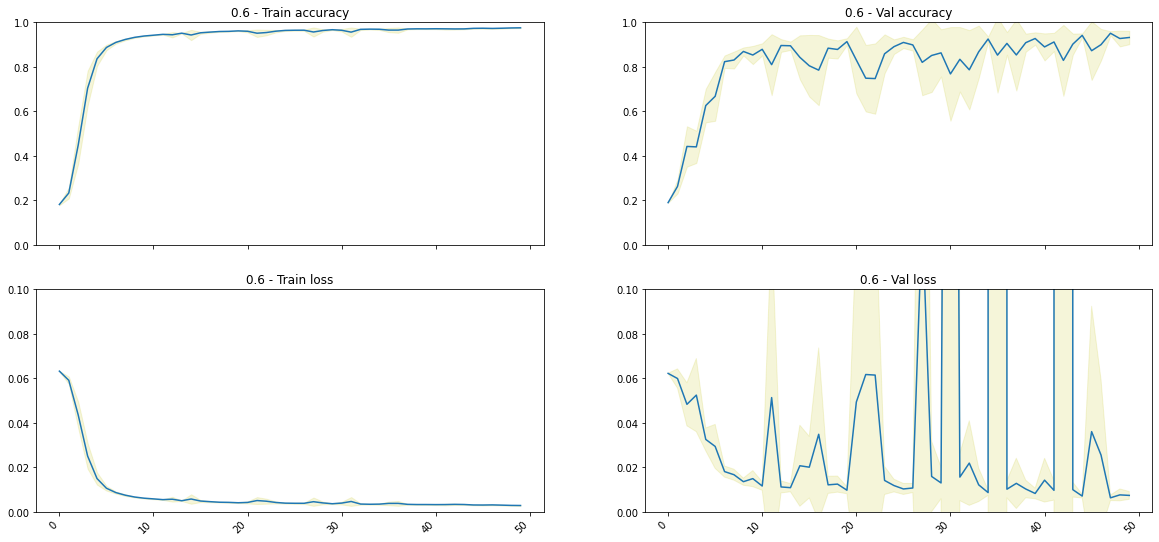

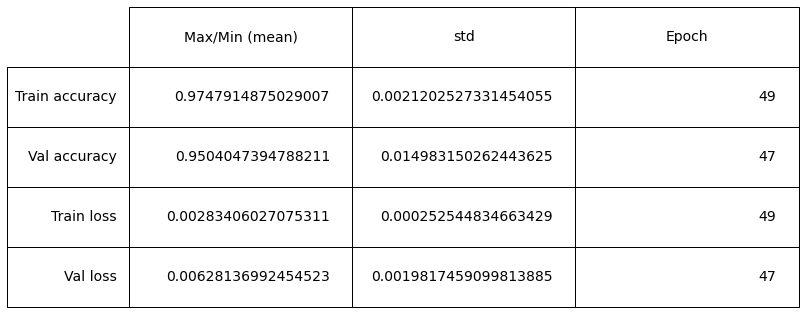

In [209]:
display(sixth_scaling, "0.6")

## Scaling factor of 0.8
As we approach a scaling factor of 1 we can see that the metrics starts to resemble the baseline. The train accuracy is steep and stabilizes quite good, similarly to the baseline model. The same can be said of the train loss.

Although the val accuracy is more stable than the two previous trials, we still see a lot of fluctuation and a bigger confidence intervall compared to the baseline.

The val loss starts with a good descent, however, it has some enormous spikes throughout the training period.


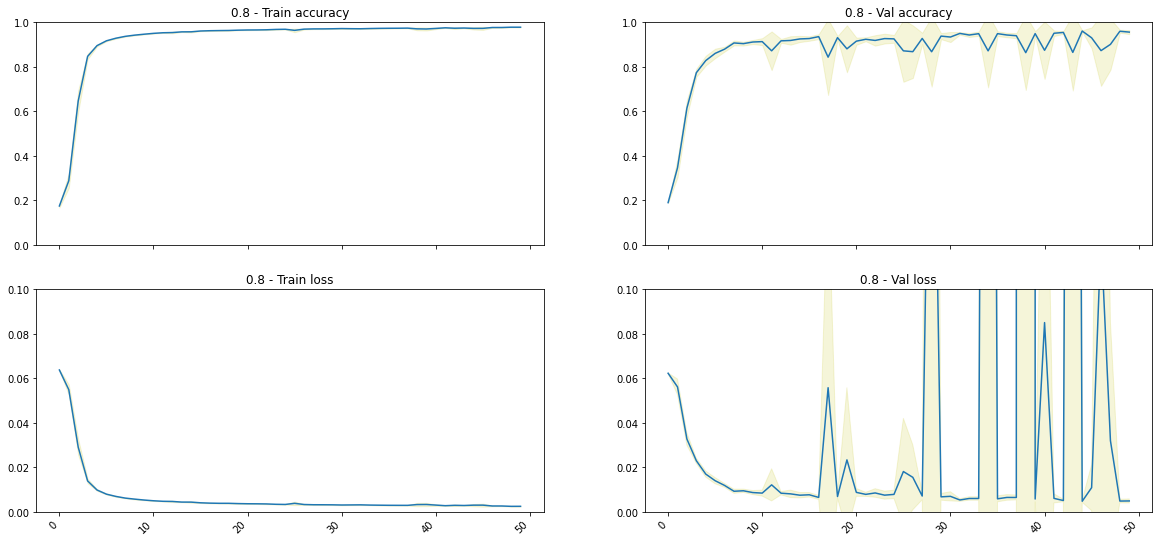

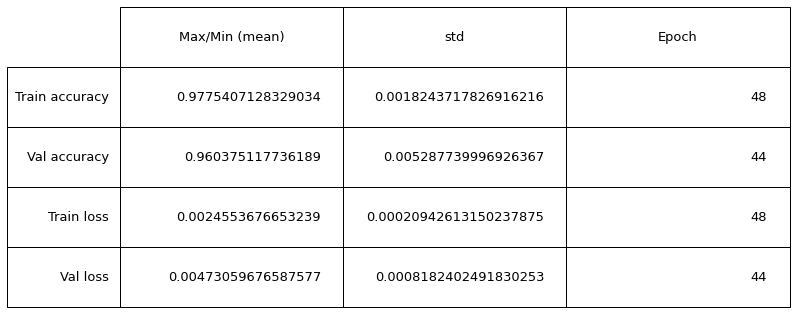

In [210]:
display(eight_scaling, "0.8")

## Scaling factor of 1.2
In this trial have a good competitor to the baseline. Both train accuracy and train loss has rapid progress before it stabilizes, while having a small confidence interval.

Looking at the val accuracy we can observe some interesting points, comparing to the baseline. We see that it has the same stable rapid progress. However, whereas the val accuracy in the baseline would have some dips, this val accuracy seem to stabilize much more and have a smaller confidence interval. The same applies to the val loss.

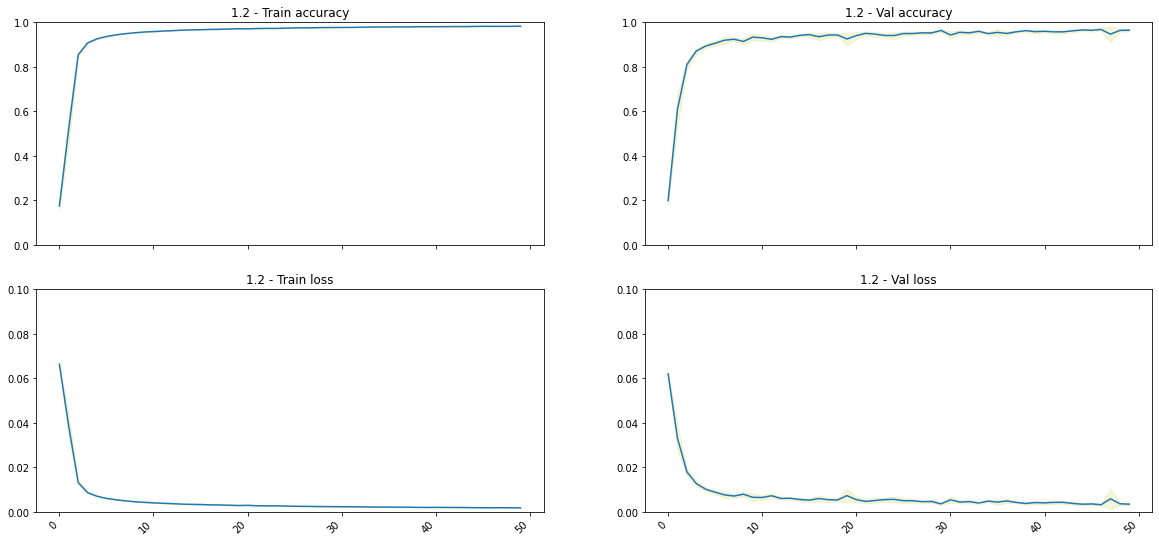

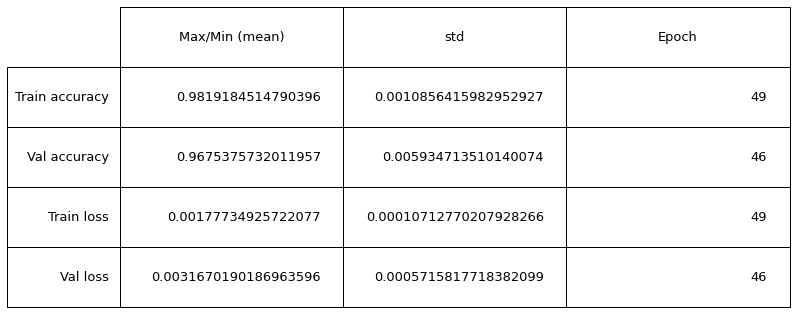

In [211]:
display(one_two_scaling, "1.2")

## Scaling factor of 1.4
This trial seems to improve even more compared to the baseline. Both train accuracy and train loss has rapid progress before stabilizing.

The val accuracy seems to stabilize even more than the previous trial, and has a even smaller confidence interval than the previous trial. The same can be said of the val loss.

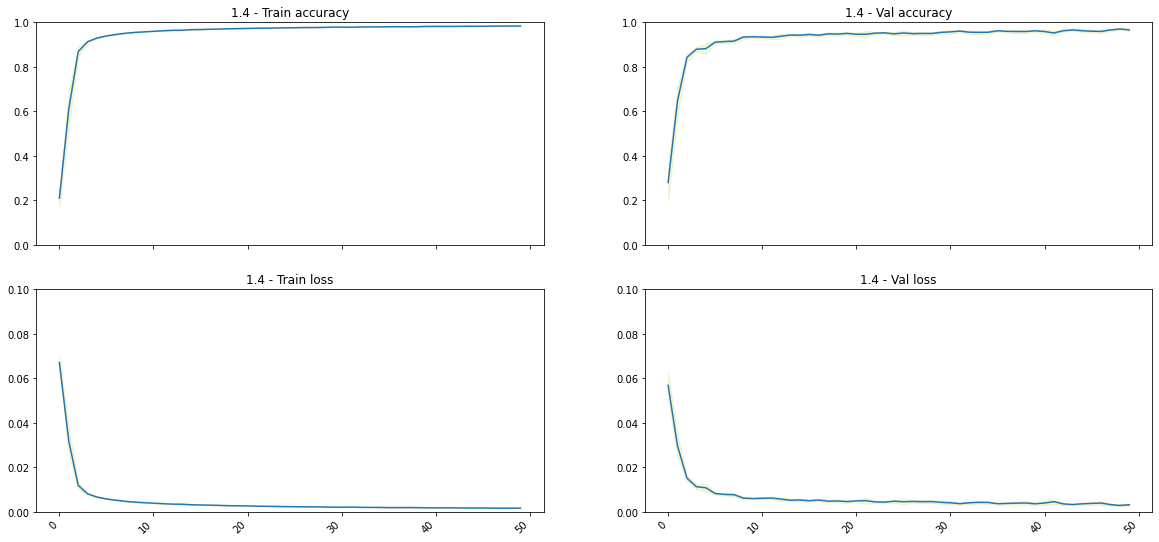

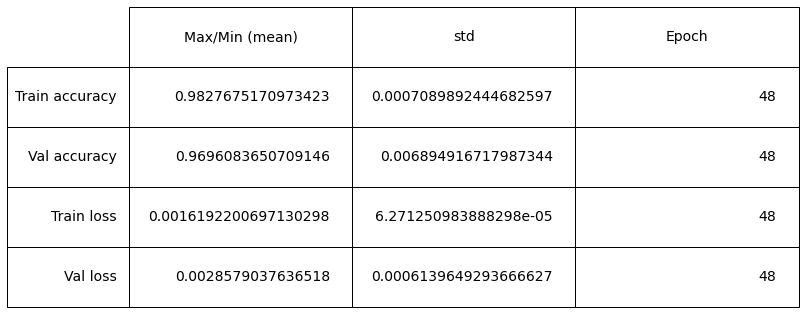

In [212]:
display(one_four_scaling, "1.4")

## Scaling factor of 1.6

The train accuracy and loss seems to follow the same path as the two previous; rapid progress then stabilizing.
However, the val accuracy and the val loss has certain points where the performance dips/spikes.

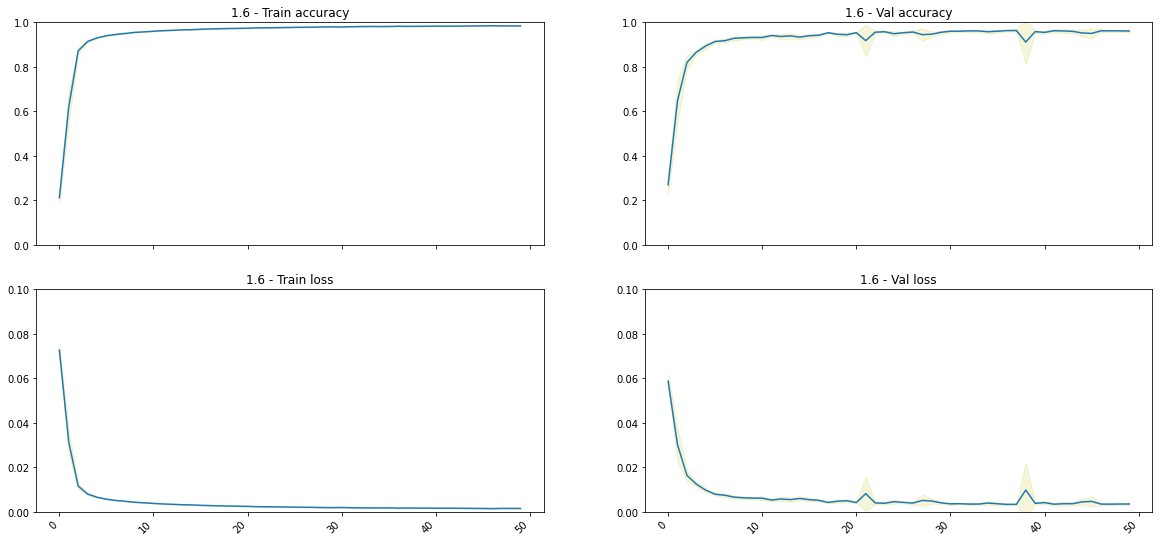

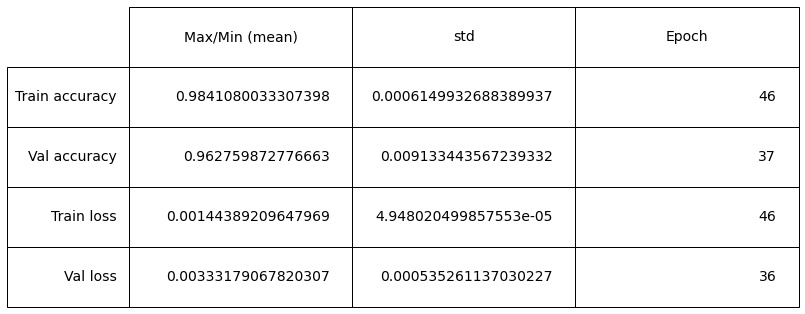

In [213]:
display(one_six_scaling, "1.6")

## Afterthoughts

It seems like the scaling factor has a effect on performance of a model. Whereas the baseline has a train accuracy max (mean) of 0.9804, the trial with 1.4 as scaling factor achieved 0.9841. It also seems like having a scaling factor > 1.0 stabilizes the val metrics compared to the baseline model.

That said, this should definitely be tested more and I will therefore add a list of possible trials in the future:
- Try even bigger scaling factors
- Try having variable scaling factor in each bottleneck.
- Try different datasets
- Try the scaling factor in vision transformers
- Try different hyper parameters